## 1) Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.utils.data import random_split

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
#from resources.plotcm import plot_confusion_matrix

import time
import random

import itertools

In [ ]:
torch.cuda.get_device_name(device=None)

'Tesla P100-PCIE-16GB'

In [ ]:
path = f'./benchmark/cm/densenet121/train'
if not os.path.exists(path):
    os.makedirs(path)

path = f'./benchmark/cm/densenet121/test'
if not os.path.exists(path):
    os.makedirs(path)

## 2) Definitions

### 2.1) Activation Functions

#### 2.1.1) Squashing Function

In [ ]:
# implement class wrapper for squashing activation function
class Squashing(nn.Module):
    def __init__(self, learnable=True, beta=1.0):
        '''
        Init method.
        '''
        super(Squashing, self).__init__()

        # initialize fix parameters
        self.alpha = 0.5
        self.lam = 1.0


        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        global betas
        #global f_beta 
        #global f_alpha 
        #global f_lam 
        #f_beta= self.beta
        #f_alpha= self.alpha
        #f_lam= self.lam 


        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )



# implement mish activation function
def f_squashing(input):
  slam = f_lam
  sbeta = f_beta
  salpha = f_alpha
  return (1/(slam * sbeta)) * torch.log( (1+torch.exp(sbeta*(input-(salpha-(slam/2)))) ) / (1+torch.exp(sbeta*(input-(salpha+(slam/2))))) )

### 2.2) Network

### 2.2.1) Densenet-121

In [ ]:
#"""Bottleneck layers. Although each layer only produces k
#output feature-maps, it typically has many more inputs. It
#has been noted in [37, 11] that a 1×1 convolution can be in-
#troduced as bottleneck layer before each 3×3 convolution
#to reduce the number of input feature-maps, and thus to
#improve computational efficiency."""
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate, activation='tanh'):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution 
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate
        
        if activation == 'squashing':
            print("squashing")
            f_activation = Squashing()
        
        elif activation == 'relu':
            print("relu")
            f_activation = nn.ReLU()
            
        elif activation == 'sigmoid':
            print("sigmoid")
            f_activation = nn.Sigmoid()
            
        elif activation == 'tanh':
            print("tanh")
            f_activation = nn.Tanh()
            
        elif (activation == 'squashing-nl'):
            print("squashing-nl")
            f_activation = Squashing(False, beta=0.6)

        #"""We find this design especially effective for DenseNet and 
        #we refer to our network with such a bottleneck layer, i.e., 
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` , 
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            f_activation,
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments 
        #consist of a batch normalization layer and an 1×1 
        #convolutional layer followed by a 2×2 average pooling 
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=10, activation = 'tanh'):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution 
        #with 16 (or twice the growth rate for DenseNet-BC) 
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each 
        #side of the inputs is zero-padded by one pixel to keep 
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(1, inner_channels, kernel_size=3, padding=1, bias=False) 
        
        if activation == 'squashing':
            print("squashing")
            f_activation = Squashing()
        
        elif activation == 'relu':
            print("relu")
            f_activation = nn.ReLU()
            
        elif activation == 'sigmoid':
            print("sigmoid")
            f_activation = nn.Sigmoid()
            
        elif activation == 'tanh':
            print("tanh")
            f_activation = nn.Tanh()
            
        elif (activation == 'squashing-nl'):
            print("squashing-nl")
            f_activation = Squashing(False, beta=0.6)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the 
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression 
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('activation', f_activation)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121(activation = 'tanh'):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32, activation = activation)

### 2.3) Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, activation='relu', network='lenet', step='train'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'./benchmark/cm/{network}/{step}/fashion-mnist_{network}_{activation}_{step}_{int(time.time())}.png', dpi=300, transparent=True, bbox_inches='tight')

## 3) Parameter

In [ ]:
epochs = 50
batch_size = 32
learning_rate = 0.0001

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

# #densenet121
network = 'densenet121'

#squashing, squashing-nl, relu, sigmoid, tanh
activation = 'tanh'

# LeNet5(activation), resnext50(activation=activation)
model = densenet121(activation=activation)

# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh
tanh


In [ ]:
device

device(type='cuda', index=0)

## 4) Datasets

In [ ]:
# definie train dataloader
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)

# definie test dataloader
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=batch_size)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## 5) Training

In [ ]:
train_stats = pd.DataFrame()

#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}.. "
          #f"Beta: {betas:.4f}"
          )

    if 'betas' in globals():
      train_stats = train_stats.append({'Epoch': int(epoch+1), 'Time per epoch':time_elapsed,
                                        'Avg time per step': time_elapsed/len(trainloader),
                                        'Train loss' : running_loss/len(trainloader),
                                        'Train accuracy': train_accuracy/len(trainloader),
                                        'Train top-3 accuracy':top3_train_accuracy/len(trainloader),
                                        'Test loss' : test_loss/len(testloader),
                                        'Test accuracy': test_accuracy/len(testloader),
                                        'Test top-3 accuracy':top3_test_accuracy/len(testloader),
                                        'Beta': betas
                                        }, ignore_index=True)
    else:
      train_stats = train_stats.append({'Epoch': int(epoch+1), 'Time per epoch':time_elapsed,
                                        'Avg time per step': time_elapsed/len(trainloader),
                                        'Train loss' : running_loss/len(trainloader),
                                        'Train accuracy': train_accuracy/len(trainloader),
                                        'Train top-3 accuracy':top3_train_accuracy/len(trainloader),
                                        'Test loss' : test_loss/len(testloader),
                                        'Test accuracy': test_accuracy/len(testloader),
                                        'Test top-3 accuracy':top3_test_accuracy/len(testloader)
                                        }, ignore_index=True)
    
    
    
    running_loss = 0
    model.train()



Epoch 1/50.. Time per epoch: 192.0495.. Average time per step: 0.1024.. Train loss: 0.3784.. Train accuracy: 0.8638.. Top-3 train accuracy: 0.9851.. Test loss: 0.2588.. Test accuracy: 0.9057.. Top-3 test accuracy: 0.9919.. 
Epoch 2/50.. Time per epoch: 191.8135.. Average time per step: 0.1023.. Train loss: 0.2395.. Train accuracy: 0.9131.. Top-3 train accuracy: 0.9938.. Test loss: 0.2491.. Test accuracy: 0.9088.. Top-3 test accuracy: 0.9933.. 
Epoch 3/50.. Time per epoch: 193.8841.. Average time per step: 0.1034.. Train loss: 0.2044.. Train accuracy: 0.9271.. Top-3 train accuracy: 0.9950.. Test loss: 0.2194.. Test accuracy: 0.9223.. Top-3 test accuracy: 0.9947.. 
Epoch 4/50.. Time per epoch: 194.4079.. Average time per step: 0.1037.. Train loss: 0.1762.. Train accuracy: 0.9367.. Top-3 train accuracy: 0.9968.. Test loss: 0.1996.. Test accuracy: 0.9287.. Top-3 test accuracy: 0.9952.. 
Epoch 5/50.. Time per epoch: 194.8206.. Average time per step: 0.1039.. Train loss: 0.1558.. Train acc

## 6) Output

In [ ]:
train_stats.to_csv(f'./benchmark/fashion-mnist_{network}_{activation}_{int(time.time())}.csv')

## 7) Confusion Matrix

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images=images.to(device)
        labels=labels.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

### 7.1) Train Set

In [ ]:
len(trainset)

60000

In [ ]:
len(trainset.targets)

60000

In [ ]:
with torch.no_grad():
    train_prediction_loader=torch.utils.data.DataLoader(trainset, batch_size=1000)
    train_preds=get_all_preds(model, train_prediction_loader).to(device)

In [ ]:
stacked_train = torch.stack(
    (
        trainset.targets.to(device),
        train_preds.argmax(dim=1)
    ),dim=1
)

In [ ]:
cmtr = torch.zeros(10,10, dtype=torch.int64)
for p in stacked_train:
    true, predicted = p.tolist()
    cmtr[true, predicted] = cmtr[true, predicted] + 1

In [ ]:
cmtr

tensor([[5932,    0,    0,   31,    0,    0,   37,    0,    0,    0],
        [   0, 6000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    0, 5995,    2,    0,    0,    2,    0,    0,    0],
        [   0,    0,    0, 5999,    1,    0,    0,    0,    0,    0],
        [   0,    0,    2,    0, 5980,    0,   18,    0,    0,    0],
        [   0,    0,    0,    0,    0, 5999,    0,    0,    0,    1],
        [   2,    0,    1,    5,    0,    0, 5992,    0,    0,    0],
        [   0,    0,    0,    0,    0,    7,    0, 5888,    0,  105],
        [   0,    0,    0,    0,    0,    0,    1,    0, 5999,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0, 6000]])

Confusion matrix, without normalization
tensor([[5932,    0,    0,   31,    0,    0,   37,    0,    0,    0],
        [   0, 6000,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    0, 5995,    2,    0,    0,    2,    0,    0,    0],
        [   0,    0,    0, 5999,    1,    0,    0,    0,    0,    0],
        [   0,    0,    2,    0, 5980,    0,   18,    0,    0,    0],
        [   0,    0,    0,    0,    0, 5999,    0,    0,    0,    1],
        [   2,    0,    1,    5,    0,    0, 5992,    0,    0,    0],
        [   0,    0,    0,    0,    0,    7,    0, 5888,    0,  105],
        [   0,    0,    0,    0,    0,    0,    1,    0, 5999,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0, 6000]])


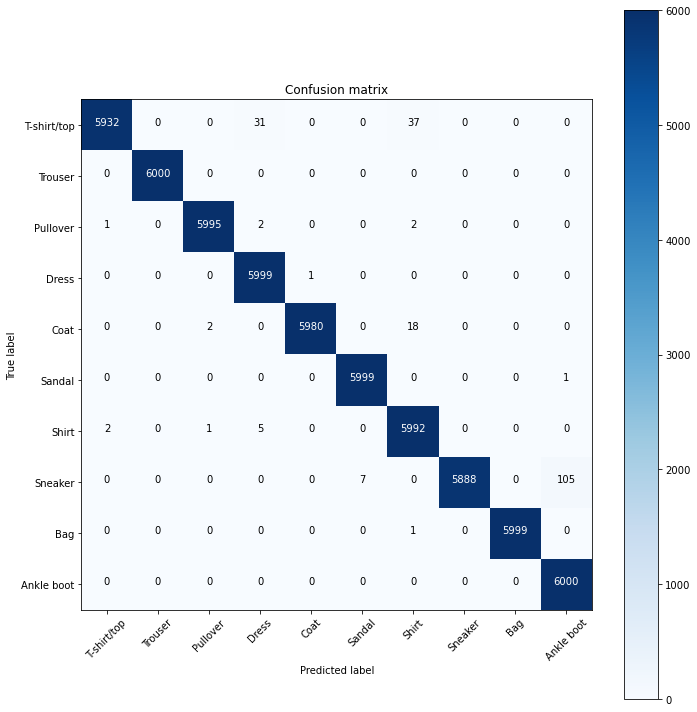

In [ ]:
names_train = tuple(trainset.classes)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmtr, names_train, activation=activation, network=network, step='train')

### 7.2) Test Set

In [ ]:
len(testset)

10000

In [ ]:
len(testset.targets)

10000

In [ ]:
with torch.no_grad():
    test_prediction_loader=torch.utils.data.DataLoader(testset, batch_size=1000)
    test_preds=get_all_preds(model, test_prediction_loader).to(device)

In [ ]:
stacked_test = torch.stack(
    (
        testset.targets.to(device),
        test_preds.argmax(dim=1)
    ),dim=1
)

In [ ]:
cmte = torch.zeros(10,10, dtype=torch.int64)
#cmt
for p in stacked_test:
    true, predicted = p.tolist()
    cmte[true, predicted] = cmte[true, predicted] + 1

In [ ]:
cmte

tensor([[849,   1,  21,  30,   2,   1,  93,   0,   3,   0],
        [  0, 987,   0,   7,   2,   0,   2,   0,   2,   0],
        [ 11,   1, 923,   5,  25,   0,  35,   0,   0,   0],
        [  3,   1,   6, 963,  13,   0,  14,   0,   0,   0],
        [  0,   0,  22,  18, 897,   0,  63,   0,   0,   0],
        [  0,   0,   0,   0,   0, 994,   0,   4,   0,   2],
        [ 61,   1,  34,  35,  36,   0, 829,   0,   4,   0],
        [  0,   0,   0,   0,   0,   7,   0, 941,   0,  52],
        [  1,   0,   1,   2,   1,   1,   3,   0, 991,   0],
        [  0,   0,   1,   0,   0,   3,   0,   5,   0, 991]])

Confusion matrix, without normalization
tensor([[849,   1,  21,  30,   2,   1,  93,   0,   3,   0],
        [  0, 987,   0,   7,   2,   0,   2,   0,   2,   0],
        [ 11,   1, 923,   5,  25,   0,  35,   0,   0,   0],
        [  3,   1,   6, 963,  13,   0,  14,   0,   0,   0],
        [  0,   0,  22,  18, 897,   0,  63,   0,   0,   0],
        [  0,   0,   0,   0,   0, 994,   0,   4,   0,   2],
        [ 61,   1,  34,  35,  36,   0, 829,   0,   4,   0],
        [  0,   0,   0,   0,   0,   7,   0, 941,   0,  52],
        [  1,   0,   1,   2,   1,   1,   3,   0, 991,   0],
        [  0,   0,   1,   0,   0,   3,   0,   5,   0, 991]])


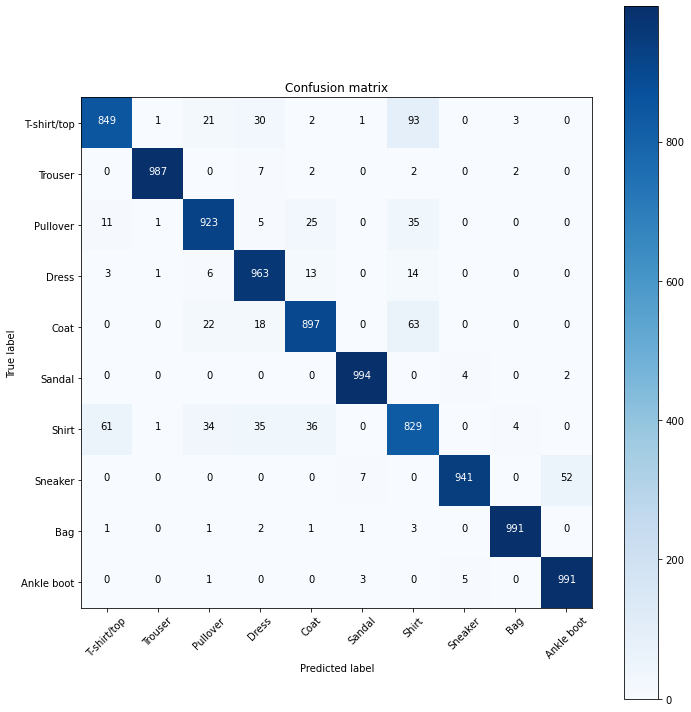

In [ ]:
names_test = tuple(testset.classes)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmte, names_test, activation=activation, network=network, step='test')

### 7.3) Save CM train and test

In [ ]:
torch.save(train_preds, f'./benchmark/cm/train_preds_{network}_{activation}.pt')
# torch.load(f'storage/benchmarks/cm/train_preds_{network}_{activation}.pt')

In [ ]:
torch.save(test_preds, f'./benchmark/cm/test_preds_{network}_{activation}.pt')
# torch.load(f'storage/benchmarks/cm/train_preds_{network}_{activation}.pt')